<a href="https://colab.research.google.com/github/Mario-td/HandGestureClassification/blob/master/2DModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **2D model selection**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  
import time
import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Path to the files
path = '/content/drive/My Drive/MastersThesis/Dataset/'
data2D = pd.read_csv(path + '/HandGesture2D.csv')

In [ ]:
# Gets the number of frames per sample
t_steps = max(data2D['Sequence']) + 1
t_steps

32

In [ ]:
# Gets the labels
Y_ = np.array(data2D['Label'][0::t_steps][:], dtype=np.int32)
Y_.size

13604

In [ ]:
# Gets the data
X_2D = pd.DataFrame.to_numpy(data2D[data2D.columns[2:]])
# Splits into the number of samples
X_2D = np.array(np.split(X_2D, Y_.size))
X_2D.shape

(13604, 32, 42)

In [ ]:
# Splits into training, and test set
X_train2D, X_test2D, y_train2D, y_test2D = train_test_split(X_2D, Y_, test_size=0.2, random_state=42)

In [ ]:
print('X_train shape '+ str(X_train2D.shape))
print('X_test shape '+ str(X_test2D.shape))

X_train shape (10883, 32, 42)
X_test shape (2721, 32, 42)


In [ ]:
# Prints the number of samples per class in the training and test set
n_classes = 5 
for i in range(n_classes):
  print('train samples %d: ' % i + str(np.count_nonzero(y_train2D == i)))
print('----------------------')
for i in range(n_classes):
  print('test samples %d: ' % i + str(np.count_nonzero(y_test2D == i)))

train samples 0: 2090
train samples 1: 2164
train samples 2: 2211
train samples 3: 2140
train samples 4: 2278
----------------------
test samples 0: 554
test samples 1: 544
test samples 2: 537
test samples 3: 548
test samples 4: 538


In [ ]:
# Adjusts the label arrays shape
y_train2D = tf.keras.utils.to_categorical(y_train2D, n_classes)
y_test2D = tf.keras.utils.to_categorical(y_test2D, n_classes)

In [ ]:
# Number of input parameters per timestep
n_input2D = len(X_train2D[0][0]) 
# Reshapes the input splitting it into subsequences
n_sub = 2
n_length = (int) (t_steps / n_sub)
X_train2D = X_train2D.reshape((X_train2D.shape[0], n_sub, n_length, n_input2D))
X_test2D = X_test2D.reshape((X_test2D.shape[0], n_sub, n_length, n_input2D))

In [ ]:
# Defines the model
model_2D = tf.keras.Sequential()
model_2D.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_sub, n_length,n_input2D)))
model_2D.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
model_2D.add(tf.keras.layers.Dropout(0.2))
model_2D.add(tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling1D(pool_size=2)))
model_2D.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()))
model_2D.add(tf.keras.layers.LSTM(200))
model_2D.add(tf.keras.layers.Dropout(0.2))
model_2D.add(tf.keras.layers.Dense(n_classes, activation='softmax'))

# **Model training**

In [ ]:
# Hyperparameters
batch_size = 1024
n_epochs = 80
opt = tf.keras.optimizers.Adam(learning_rate=0.0011, beta_1=0.9, beta_2=0.999, amsgrad=False)

model_2D.compile(loss='categorical_crossentropy', optimizer= opt, metrics=['accuracy'])

# Measures the training time
t_start = time.time()
history = model_2D.fit(X_train2D, y_train2D, shuffle=True, batch_size=batch_size, epochs=n_epochs)
t_stop = time.time() 
print( "Training time: " + str(datetime.timedelta(seconds= t_stop - t_start)))

Epoch 1/80
 1/11 [=>............................] - ETA: 0s - loss: 1.7718 - accuracy: 0.2217WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
11/11 [==============================] - 2s 189ms/step - loss: 1.6072 - accuracy: 0.2791
Epoch 2/80
11/11 [==============================] - 2s 185ms/step - loss: 1.4758 - accuracy: 0.3671
Epoch 3/80
11/11 [==============================] - 2s 184ms/step - loss: 1.3205 - accuracy: 0.4490
Epoch 4/80
11/11 [==============================] - 2s 184ms/step - loss: 1.1946 - accuracy: 0.5034
Epoch 5/80
11/11 [==============================] - 2s 186ms/step - loss: 1.0429 - accuracy: 0.5903
Epoch 6/80
11/11 [==============================] - 2s 186ms/step - loss: 0.8672 - accuracy: 0.6687
Epoch 7/80
11/11 [======================

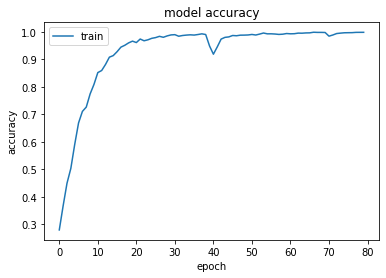

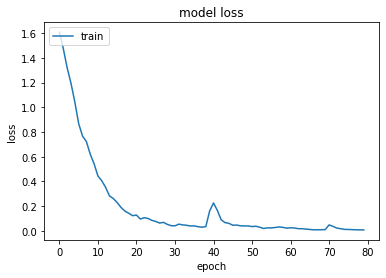

In [ ]:
# Summarizes history for accuracy
plt.plot(history.history['accuracy']) 
plt.title('model accuracy') 
plt.ylabel('accuracy') 
plt.xlabel('epoch') 
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Summarizes history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# **Model evaluation**

In [ ]:
# Evaluates the model with the test set
model_2D.evaluate(X_test2D, y_test2D)

86/86 [==============================] - 0s 5ms/step - loss: 0.0141 - accuracy: 0.9978


[0.014063396491110325, 0.9977949261665344]

In [ ]:
predicted_classes = model_2D.predict_classes(X_test2D) 
# Sets the actual test label with the same format
y_test2D = y_test2D.argmax(1)

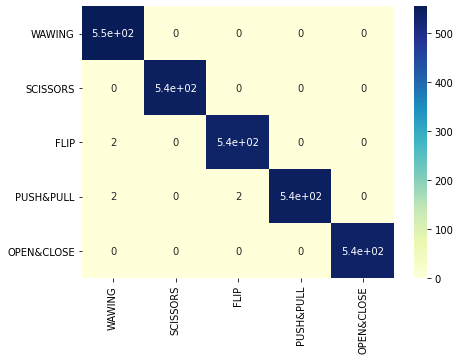

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Label of the classes
LABELS = [    
    'WAWING',
    'SCISSORS',
    'FLIP',
    'PUSH&PULL',
    'OPEN&CLOSE'
] 

cm = confusion_matrix(y_test2D, predicted_classes)
cm
plt.figure(figsize = (7, 5))
sns.heatmap(cm, annot = True, xticklabels = LABELS, yticklabels = LABELS, cmap="YlGnBu")

In [ ]:
# Saves the parameters
model_2D.save_weights(path + 'WEIGHTS-2D.ckpt')
model_2D.save(path + 'MODEL-2D.h5')